In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

#### 로드

In [6]:
df= pd.read_csv('KOPN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-07,1.85,1.87,1.72,1.74,1.74,424400
1,2016-03-08,1.73,1.73,1.67,1.68,1.68,315200
2,2016-03-09,1.68,1.74,1.65,1.71,1.71,155900
3,2016-03-10,1.74,1.74,1.68,1.69,1.69,160300
4,2016-03-11,1.71,1.76,1.70,1.76,1.76,250000


#### 고가,저가, 중간값

In [7]:
high=df['High'].values
low=df['Low'].values
mid=(high+low)/2
mid

array([1.795, 1.7  , 1.695, ..., 9.14 , 8.48 , 7.425])

#### 윈도우지정 30일

In [8]:
seq_len=30
#seq_len으로 다음 1일 예측해야하기 때문에 Sequence_length 생성
sequence_length=seq_len+1

#31개 씩 저장
result = []
for i in range(len(mid)-sequence_length):
    result.append(mid[i:i+sequence_length])

In [9]:
result

[array([1.795, 1.7  , 1.695, 1.71 , 1.73 , 1.81 , 1.77 , 1.73 , 1.77 ,
        1.76 , 1.765, 1.71 , 1.695, 1.6  , 1.605, 1.645, 1.71 , 1.695,
        1.675, 1.69 , 1.645, 1.665, 1.675, 1.71 , 1.845, 1.84 , 1.87 ,
        1.85 , 1.8  , 1.755, 1.72 ]),
 array([1.7  , 1.695, 1.71 , 1.73 , 1.81 , 1.77 , 1.73 , 1.77 , 1.76 ,
        1.765, 1.71 , 1.695, 1.6  , 1.605, 1.645, 1.71 , 1.695, 1.675,
        1.69 , 1.645, 1.665, 1.675, 1.71 , 1.845, 1.84 , 1.87 , 1.85 ,
        1.8  , 1.755, 1.72 , 1.7  ]),
 array([1.695, 1.71 , 1.73 , 1.81 , 1.77 , 1.73 , 1.77 , 1.76 , 1.765,
        1.71 , 1.695, 1.6  , 1.605, 1.645, 1.71 , 1.695, 1.675, 1.69 ,
        1.645, 1.665, 1.675, 1.71 , 1.845, 1.84 , 1.87 , 1.85 , 1.8  ,
        1.755, 1.72 , 1.7  , 1.675]),
 array([1.71 , 1.73 , 1.81 , 1.77 , 1.73 , 1.77 , 1.76 , 1.765, 1.71 ,
        1.695, 1.6  , 1.605, 1.645, 1.71 , 1.695, 1.675, 1.69 , 1.645,
        1.665, 1.675, 1.71 , 1.845, 1.84 , 1.87 , 1.85 , 1.8  , 1.755,
        1.72 , 1.7  , 1.675, 1.725

#### 정규화

In [11]:
normal=[]
# (당일 중간값 정규화 / 전날 중간값을 정규화 ) -1
for a in result:
    normalized_window=[((float(p)/float(a[0]))-1) for p in a]
    normal.append(normalized_window)

In [14]:
result=np.array(normal)

In [15]:
result

array([[ 0.        , -0.05292479, -0.05571031, ...,  0.00278552,
        -0.02228412, -0.04178273],
       [ 0.        , -0.00294118,  0.00588235, ...,  0.03235294,
         0.01176471,  0.        ],
       [ 0.        ,  0.00884956,  0.02064897, ...,  0.01474926,
         0.00294985, -0.01179941],
       ...,
       [ 0.        ,  0.00738552,  0.05908419, ...,  1.5745938 ,
         1.76514032,  2.16395864],
       [ 0.        ,  0.05131965,  0.08211144, ...,  1.74486804,
         2.14076246,  1.68035191],
       [ 0.        ,  0.0292887 ,  0.17154812, ...,  1.9874477 ,
         1.54951185,  1.36541144]])

#### split

In [22]:
# split train and test data  > 9:1
# 30개 데이터로 마지막 1일 예측

row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1105, 30, 1) (123, 30, 1)
(1105,) (123,)


In [25]:
model=Sequential()
model.add(LSTM(30,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [33]:
hist=model.fit(x_train,y_train,
         validation_data=(x_test,y_test),
         batch_size=10,
         epochs=10)

Epoch 1/10
111/111 [==============================] - 2s 17ms/step - loss: 0.0014 - val_loss: 0.2528
Epoch 2/10
111/111 [==============================] - 2s 18ms/step - loss: 0.0014 - val_loss: 0.2549
Epoch 3/10
111/111 [==============================] - 2s 18ms/step - loss: 0.0014 - val_loss: 0.2303
Epoch 4/10
111/111 [==============================] - 2s 19ms/step - loss: 0.0013 - val_loss: 0.2631
Epoch 5/10
111/111 [==============================] - 2s 21ms/step - loss: 0.0014 - val_loss: 0.2379
Epoch 6/10
111/111 [==============================] - 2s 21ms/step - loss: 0.0013 - val_loss: 0.2143
Epoch 7/10
111/111 [==============================] - 2s 19ms/step - loss: 0.0014 - val_loss: 0.2318
Epoch 8/10
111/111 [==============================] - 2s 18ms/step - loss: 0.0013 - val_loss: 0.2222
Epoch 9/10
111/111 [==============================] - 2s 18ms/step - loss: 0.0013 - val_loss: 0.2359
Epoch 10/10
111/111 [==============================] - 2s 20ms/step - loss: 0.0013 - val_lo

No handles with labels found to put in legend.


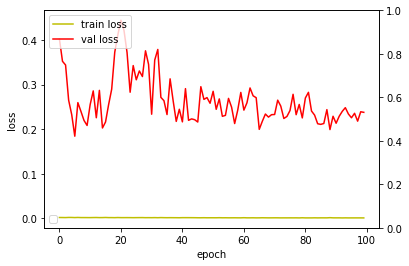

In [32]:
# 5. t손실값 측정
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

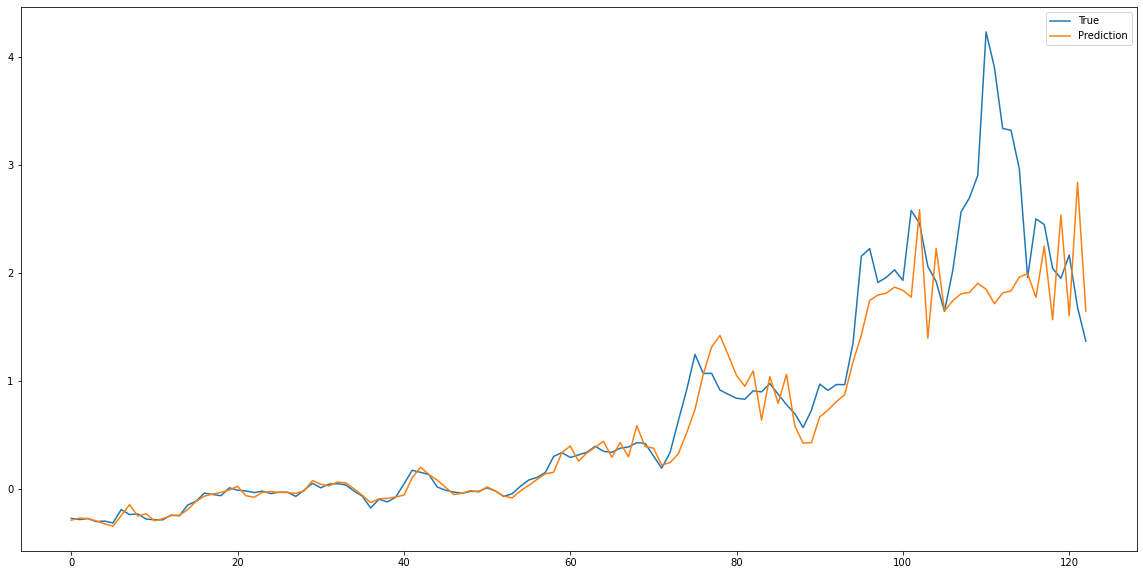

In [35]:
predict = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(predict, label='Prediction')
ax.legend()
plt.show()